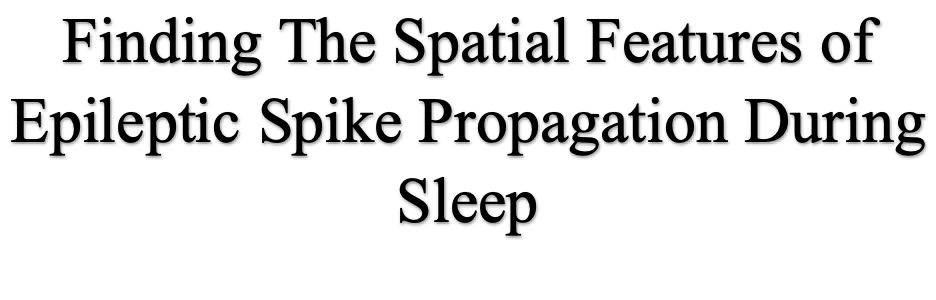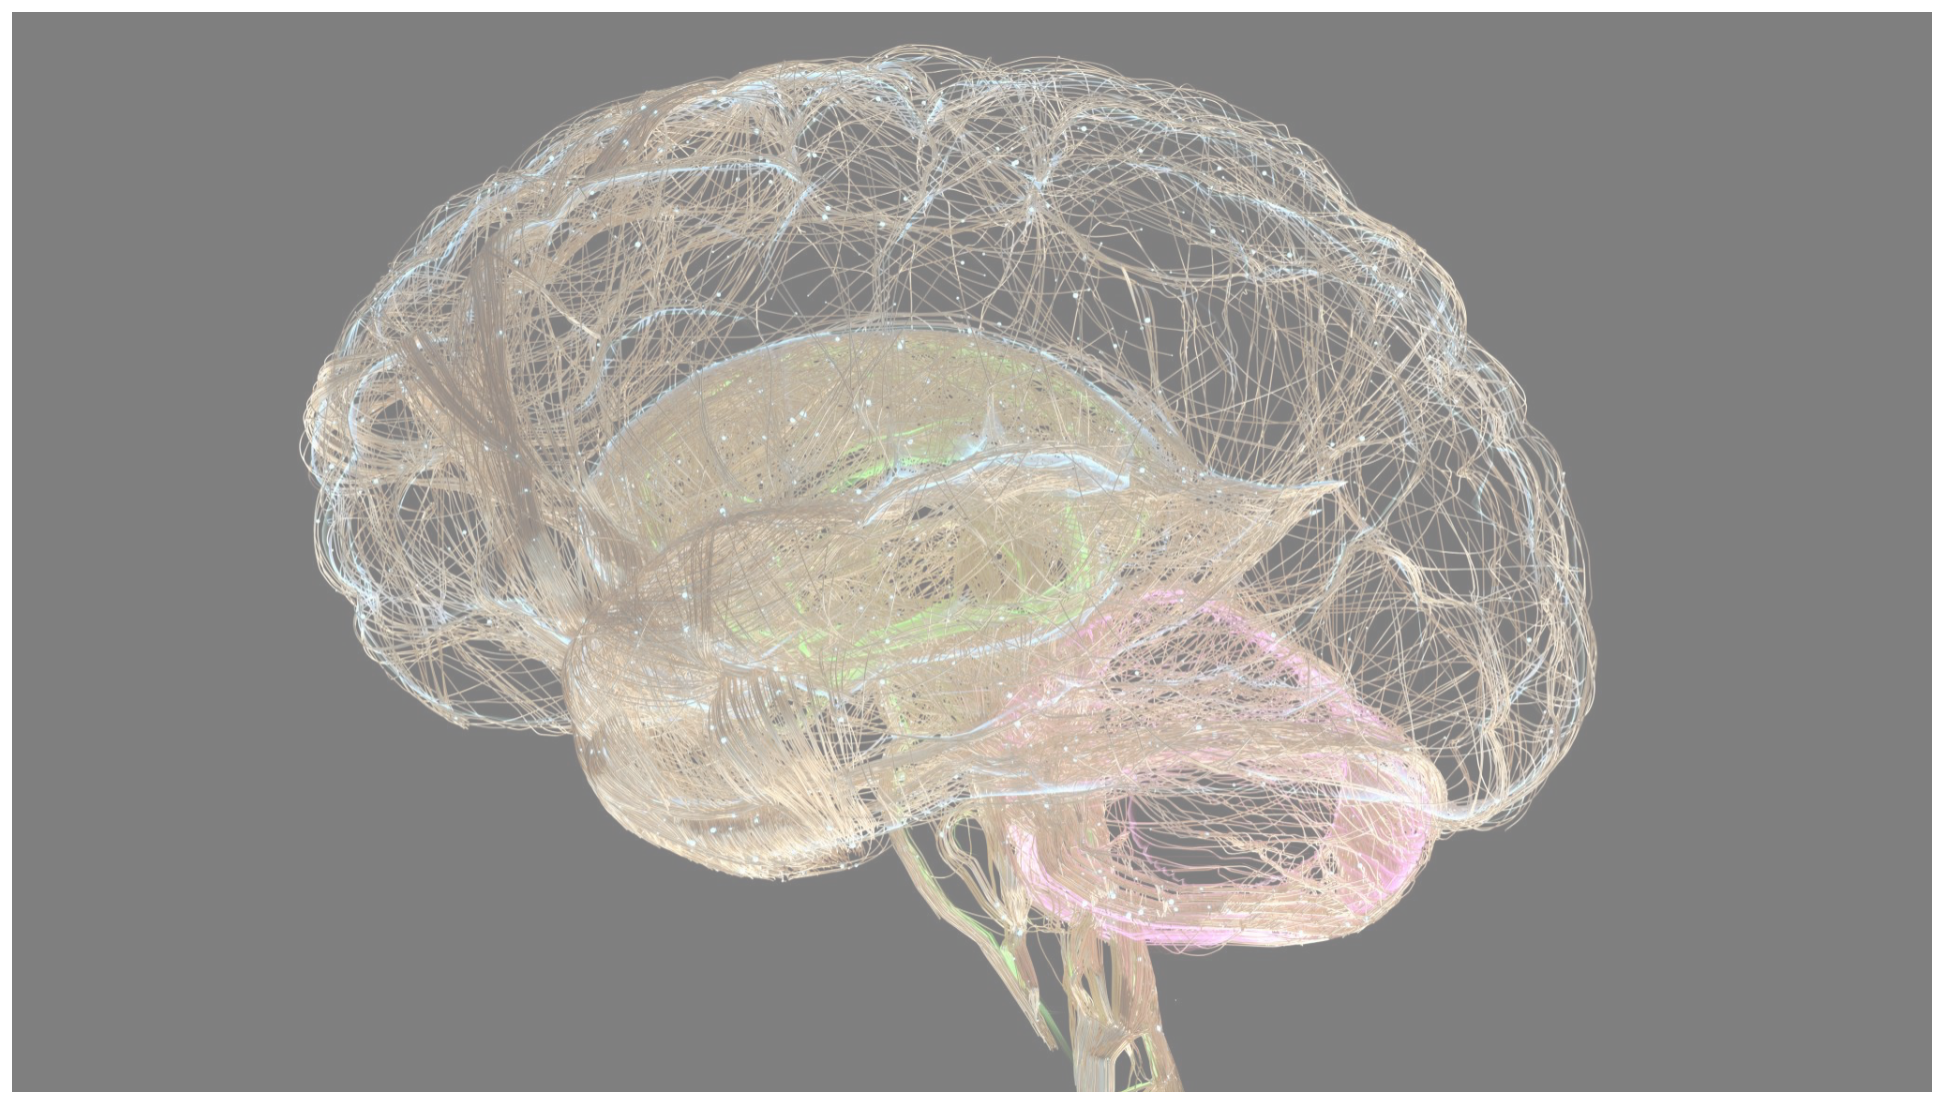

In [ ]:
from NirsLabProject.config.consts import *
from NirsLabProject.config.subject import Subject
from NirsLabProject.utils import general_utils
from NirsLabProject.utils import scalp_spikes_detection
from NirsLabProject.utils import intracranial_spikes_detection
from NirsLabProject.utils import pipeline_utils
from NirsLabProject.utils.sleeping_utils import *
from NirsLabProject.utils import plotting
from NirsLabProject.config.paths import Paths

---

</br>

## Reading a subject's iEEG and EEG data
-In this case, p13 is a patient selected from a collaborative set of experiments conducted in collaboration with Sourasky Medical Center.

-We will use biploar model

In [ ]:
subject = Subject('p13', bipolar_model=True)

In [ ]:
ieeg_raw, eog_raw = pipeline_utils.resample_and_filter_data(subject)

---
</br>

## Viewing the Electrodes Location in 3D

In [ ]:
import IPython
iframe = ' <iframe  width="900"  height="650"  frameborder="0"  scrolling="no"  src="../data/products/p396/electrodes/electrodes.html"></iframe>'
IPython.display.HTML(iframe)

---
</br>

## Scalp Detection
Using EOG channels

In [ ]:
scalp_spikes_windows = scalp_spikes_detection.detect_spikes_of_subject(subject, eog_raw)

---
</br>

## Intracranial Detection
Using the iEEG channels

In [ ]:
intracranial_spikes_windows = intracranial_spikes_detection.detect_spikes_of_subject(subject, ieeg_raw)

---
</br>

## Extracting Spatial Spikes Feature
- Finding the precise timing of the spikes within the time window
- Extracting spatial features of the intracranial spikes
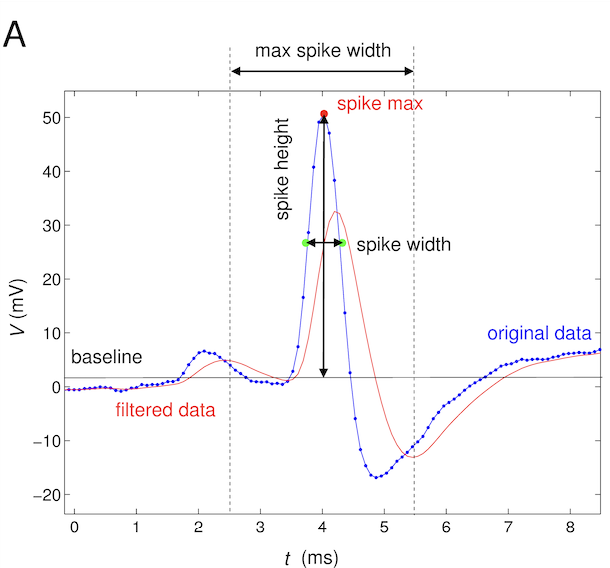
</br>

- Grouping the spikes into multi-channels events
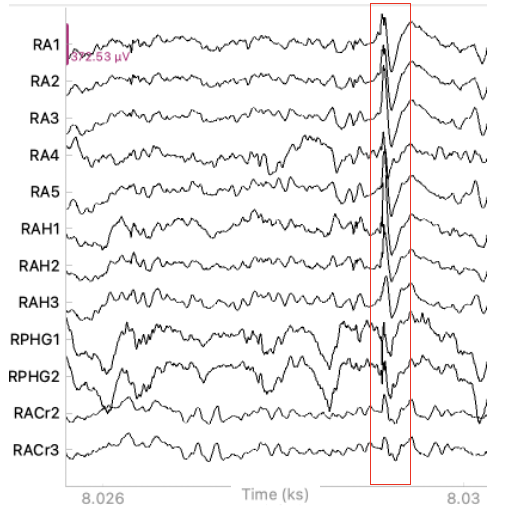
</br>

- Add a flag with boolean value for all intracranial spikes that was detected also by the scalp model
- Add featrues of sleeping and stimuli stage (in this case we don't have the data)

In [ ]:
# extracts spikes features
channels_spikes_features = pipeline_utils.extract_spikes_features(subject, ieeg_raw, intracranial_spikes_windows)
index_to_channel = pipeline_utils.get_index_to_channel(subject, channels_spikes_features)
channel_to_index = {channel:index for index, channel in index_to_channel.items()}

# extracts groups features
multi_channle_events, flat_features = pipeline_utils.group_spikes(subject, channels_spikes_features, index_to_channel)

# adds scalp spikes flag to the features
flat_features = general_utils.add_flag_of_scalp_detection_to_spikes_features(flat_features, scalp_spikes_windows)

# adds stimuli flag to the features
flat_features = general_utils.add_stimuli_flag_to_spikes_features(subject, flat_features)

# adds sleeping stage flag to the features
flat_features = general_utils.add_sleeping_stage_flag_to_spike_features(subject, flat_features)

# adds subject id to the features
subject_id = np.ones((flat_features.shape[0], 1)) * subject.p_number
flat_features = np.concatenate((flat_features, subject_id), axis=1)

---
</br>

##  Create Raster Plot
Ability too observe the behavior of various channels and identify patterns

In [ ]:
# converting the timestamps to seconds
channel_spikes = {channel_name: channel_spikes[:, TIMESTAMP_INDEX] / SR for channel_name, channel_spikes in
                  channels_spikes_features.items()}
eog_channels_spikes = {'EOG1': [spike for spike in scalp_spikes_windows]}
channel_spikes.update(eog_channels_spikes)
    
# raster plot with histogram
plotting.create_raster_plot(
    subject=subject,
    spikes=channel_spikes,
    tmin=ieeg_raw.tmin,
    tmax=ieeg_raw.tmax,
    add_hypnogram=False,
    add_histogram=True,
    show=True,
)

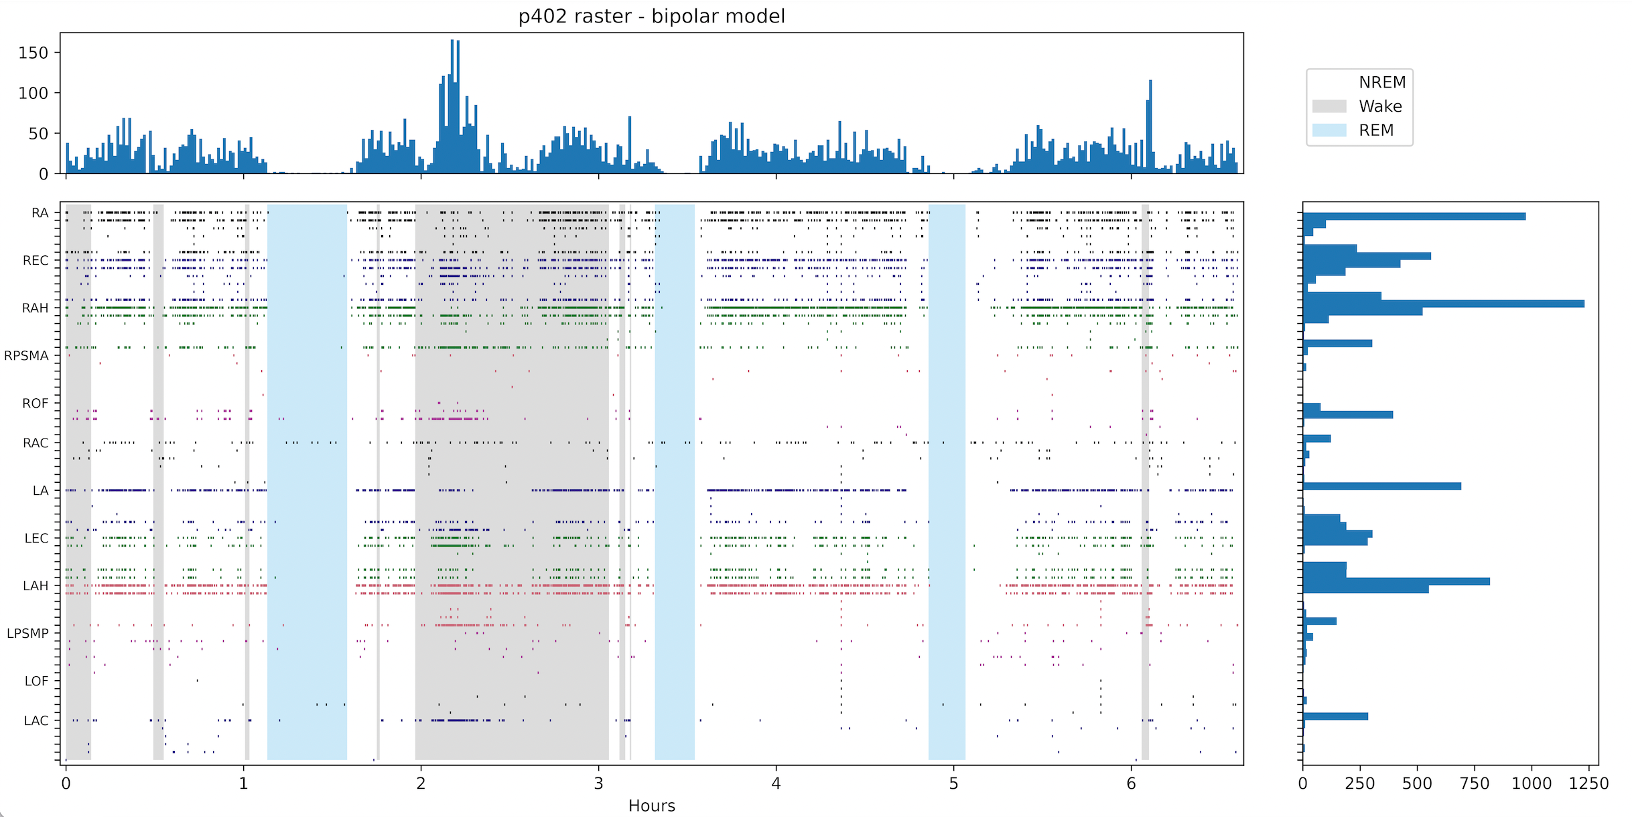
----
</br>

## Analyze and Comapre Specific Channels
One can choose different intracranial channels and comapre them using different plots:
- ERP
- PSD
- TFR
- Histograms

In [ ]:
plotting.create_erp_for_channel(subject, "RMH1", ieeg_raw, flat_features, channel_to_index, show=True)
plotting.create_erp_for_channel(subject, "RTP4", ieeg_raw, flat_features, channel_to_index, show=True)

In [ ]:
plotting.create_psd_for_channel(subject, "RMH1", ieeg_raw, flat_features, channel_to_index, show=True)
plotting.create_psd_for_channel(subject, "RTP4", ieeg_raw, flat_features, channel_to_index, show=True)

In [ ]:
plotting.create_tfr_for_channel(subject, "RMH1", ieeg_raw, flat_features, channel_to_index, show=True)
plotting.create_tfr_for_channel(subject, "RTP4", ieeg_raw, flat_features, channel_to_index, show=True)

In [ ]:
plotting.create_histogram_for_channel(subject, "RMH1", flat_features, channel_to_index, show=True)
plotting.create_histogram_for_channel(subject, "RTP4", flat_features, channel_to_index, show=True)

---
</br>
</br>
</br>
</br>


## Intersubjects Analysis of Fetures
Comparing spatial features among spikes identified by both the scalp model and the intracranial model versus spikes solely detected by the intracranial model:

In [ ]:
# all subjects
subjects = [Subject(d, True) for d in os.listdir(Paths.products_data_dir_path) if d.startswith('p')]
# only detection projects
subjects = filter(lambda subj: not subj.stimuli_project, subjects)
# only subjects with features
subjects = filter(lambda subj: os.path.exists(subj.paths.subject_flat_features_path), subjects)
# no Sourasky subjects
subjects = filter(lambda subj: not subj.sourasky_project, subjects)

flat_features, index_to_channel = pipeline_utils.get_features_of_subjects(subjects)
subject = Subject(DETECTION_PROJECT_INTERSUBJECTS_SUBJECT_NAME, True)
plotting.create_raincloud_plot_for_all_spikes_features(subject, flat_features, show=True)

</br>

---
</br>

## Identifying the Optimal Detectable Regions

In [ ]:
import IPython
iframe = '<iframe width="900" height="650" frameborder="0" scrolling="no" src="../data/products/d1/bipolar_model/plots/Features_3D/detection_probability_in_scalp.html"></iframe>'
IPython.display.HTML(iframe)

</br>

---
</br>
</br>
</br>

# Stimuli Prpject

## Stimuli Effects
The impact of stinuli on various spatial fetures:
- The average amplitude of the IEDs during the stimuli period increased by 40%.
- The spatial propagation of multi-channel events decreased by an average of 125%.
- The average spike width of the IEDs during the stimuli period decreased by 10%.

In [ ]:
from NirsLabProject.utils import pipeline_utils
pipeline_utils.stimuli_effects(show=True)